<h1>Sampling Experimentation</h1>

First, the packages needed for the experiment are imported and relevant measures such as bounds and error for correlation are set.

In [74]:
#import packages and define the model to sample from
from math import sqrt
import statistics
from collections import deque
from numpy.random import Generator, PCG64
import random
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
font = {
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# LPS: I've un-hardcoded the maximum distance at which we sample data. 
# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
MaxDistance = 4000
e = 0.15 #error value
# LPS: I've un-hardcoded the true value as we might want to play with this later. 
ValueTRUE = 400
iterations = 1000 #the maximum no. of iterations for each sample
UpperBound = MaxDistance#4000
reps = 1000 #how many times to repeat the whole experiment
rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting

<h2>Generating Noisy Artificial Data</h2>

In [75]:
#np.#random.seed(8)
dictsize = 100               

my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed; reset before each algorithm run

def getNoise(d):
    d = round(d) #round to the nearest integer
    count = my_dict[d]
    my_dict[d] += 1 #noise for d value accessed once; increment counter to get different noise
    if(my_dict[d] == dictsize):

        print("dict limit reached for value: ",d)
        my_dict[d] = 0 #cycle back to avoid going out of bounds
    return error_arrays[count][d]

error_arrays = []
for i in range(0,dictsize):
    rng = Generator(PCG64(seed=i))
    error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
    error_arrays.append(error_array)


#function to calculate correlation (rho) for distance to cell, d, and correlation distance, D
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

#generate correlation value using the function above, with corr. distance fixed  (D=400km). Distance to grid cell, d, is the input parameter. 
def generate_value(d,err): 
    rho = cordist(d,ValueTRUE) #We know that the true value of D is 400km
    noisyrho = rho + getNoise(d)  #add random error to rho, taken from a normal distribution with mean = 0 and standard deviation = e
    return(noisyrho) #returns the resulting noisy correlation value


    

<h2>Test Noise</h2>

In [76]:
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))
print(getNoise(300))
print(getNoise(300))
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))

0.18048884311747468
-0.08891617915712234
0.23742084180381995
0.18048884311747468


<h2>Random Point Generation</h2>

D-hat estimate:  [378.07226606]
covariance:  [[100.729634]]
63.69616873214543
26.97867137638703


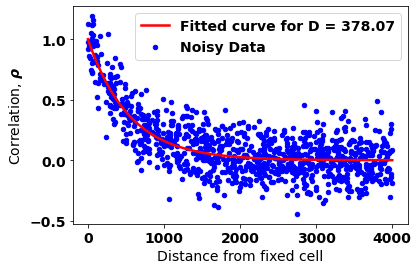

In [77]:

#np.#random.seed(8)
my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed
#a function that generates n random samples, with distance values of a given range
def generate_random_samples(n,lower_bound,upper_bound,err): 
    rng = Generator(PCG64(seed=0))
    x = []
    y = []
    for i in range(n): 
        d= rng.uniform(low=lower_bound,high=upper_bound,size=1)[0] #generate random distance value from fixed cell as a sample from a uniform distribution, in the range L.B. to U.B.
        rho_noisy = generate_value(d,err)
        
        x.append(d)
        y.append(rho_noisy)
    return (x,y)

#Generate scatter plot of distance vs correlation, with random colors to help differentiate overlapping points. 
m = 1000 #number of samples
x,y = generate_random_samples(m,0,MaxDistance,e) #pass distance bounds and st. error
plt.figure(0)
plt.scatter(x,y, c='blue', s=20) 

plt.xlabel("Distance from fixed cell")
plt.ylabel(r'Correlation, $\rho$')
#plt.title("Scatter plot of generated distance and correlation values")

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit curve with generated data and initial guess for parameter as 400km

print("D-hat estimate: ", params) #this prints the value of b (corr. distance) estimated from the curve fit on the generated data
print("covariance: ", covs)

#Plot the fitted curve by calculating y values based on rho without noise
axis_d = np.array(range(MaxDistance)) #prepare the axis for the fitted line
yfit = 2**(-axis_d/params[0]) #use the estimated D-hat for the fitted line
plt.plot(axis_d, yfit, c='red',linewidth='2.5')
l_strg = "Fitted curve for " + "D" + " = " + str(round(params[0],2))
plt.legend((l_strg,'Noisy Data'))

rng = Generator(PCG64(seed=0))
print(rng.uniform(low=0,high=100,size=1)[0])
print(rng.uniform(low=0,high=100,size=1)[0])



<h2>Adjusted Binary Search With Randomness</h2>

In [78]:
#np.#random.seed(8)

def samplechoice(lb,ub,numpoints):#calculate points and randomness range
    
    step = (ub - lb) / numpoints

    pts = [(lb+i*step) for i in range(0,numpoints)]
    randrange = (ub-lb)/(numpoints) 

    return(pts,randrange)
#Holds list of values for each repetition
Dhat_arr2_lst = [  ]
cov_arr2_lst = [  ]
x2_lst = [  ]
y2_lst = [  ]

my_dict = {key: 0 for key in range(0, UpperBound+1)}

#Repeat the whole algorithm a certain number of repetitions. Generate a new set of noise grids for each repetition, using the repetition number as the randomness seed.
for a in range(0,reps):
    my_dict = {key: 0 for key in range(0, UpperBound+1)}
    error_arrays = []
    rng = Generator(PCG64(seed=a))
    rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting
    for i in range(0,dictsize):

        #error_array = np.random.normal(0, e, size=4001) 
        error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
        error_arrays.append(error_array)

    rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting
    
    Dhat_arr2 = [  ]
    cov_arr2 = [  ]
    x = [  ]
    y = [  ]

    i_arr = []  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.
    pts, randrange = samplechoice(LowerBound,MaxDistance,4) #generate 4 equidistant points with some noise range for randomness

    for i in range(1,iterations):
        i_arr.append(i) #update every iteration

        for j in pts:
            d = j + np.random.uniform(-1*randrange,randrange) #add some noise to ensure different distances are sampled each time
            while(d > MaxDistance or d < LowerBound): #if distance is outside bounds, resample
                d = j + np.random.uniform(-1*randrange,randrange)

            rho = generate_value(d,e)
            x.append(d)
            y.append(rho)


        params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
        Dhat_arr2.append(params[0]) #new estimate of corr. dist added to D-hat list
        cov_arr2.append(np.sqrt(covs[0][0]))
    
    Dhat_arr2_lst.append(Dhat_arr2)
    cov_arr2_lst.append(cov_arr2)
    x2_lst.append(x)
    y2_lst.append(y)





/Users/mustafamajid/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-75-5dd2c28a7939>:25: RuntimeWarning: overflow encountered in power
  rho = 2**(-d/D)


<h2>Plotting</h2>

p0 value: 868.0289400313164
error value: 0.15


(0.0, 1000.0)

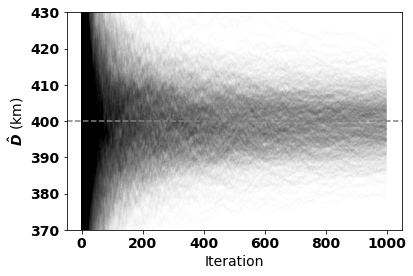

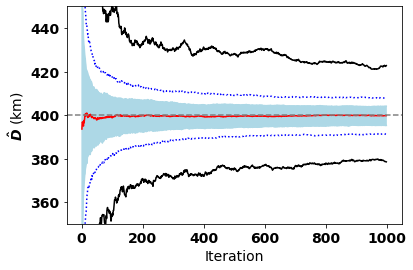

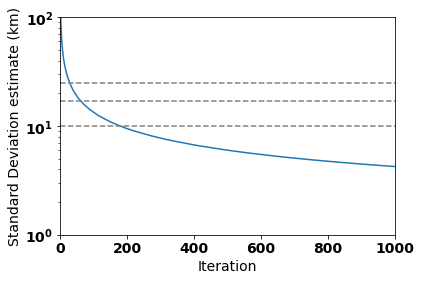

In [79]:
print("p0 value:",rp0)
print("error value:",e)

def absdiff(i):
    return (i-ValueTRUE)


plt.figure(8)
for i in range(0,len(Dhat_arr2_lst)):
    plt.plot(i_arr,Dhat_arr2_lst[i], label = 'V2',alpha=0.01,color='black') #v2  
plt.axhline(y=ValueTRUE, color='gray', linestyle='--')
plt.ylim([370,430])
plt.ylabel('$\hat{D}$ (km)')
plt.xlabel('Iteration')  

Dhat_min = []
Dhat_max = []
Dhat_med = []
Dhat_q1 = []
Dhat_q3 = []
Dhat_10 = []
Dhat_90 = []
std_med = []

for i, items in enumerate(zip(*Dhat_arr2_lst)):
    # Find min, max, and median for each iteration
    minv = min(items)
    maxv = max(items)
    quartiles = statistics.quantiles(items) #gets the 3 quartiles
    percentile_10 = statistics.quantiles(items, n=10)[0]
    percentile_90 = statistics.quantiles(items, n=10)[-1]
    Dhat_min.append(minv)
    Dhat_max.append(maxv)
    Dhat_q1.append(quartiles[0])
    Dhat_q3.append(quartiles[2])
    Dhat_med.append(quartiles[1])
    Dhat_10.append(percentile_10)
    Dhat_90.append(percentile_90)

for j, items in enumerate(zip(*cov_arr2_lst)):
    median = statistics.median(items)
    std_med.append(median)
    

plt.figure(77)
plt.plot(i_arr,Dhat_min, c='black')
plt.plot(i_arr,Dhat_max, c='black')

plt.plot(i_arr,Dhat_q1, color='lightblue')
plt.plot(i_arr,Dhat_med,color = 'red')
plt.plot(i_arr,Dhat_q3, color='lightblue')
plt.plot(i_arr,Dhat_10, color='blue',linestyle = 'dotted')
plt.plot(i_arr,Dhat_90, color='blue',linestyle = 'dotted')

plt.fill_between(i_arr, Dhat_q1, Dhat_q3, color='lightblue')

plt.ylim([350,450])
plt.ylabel('$\hat{D}$ (km)')
plt.xlabel('Iteration') 
plt.axhline(y=(ValueTRUE), color='gray', linestyle='--')
#plt.legend(loc="upper right")


#Plot median of st. dev. at each iteration
plt.figure(60)
plt.plot(i_arr,std_med, label = 'V2')
plt.axhline(y=(10), color='gray', linestyle='--')
plt.axhline(y=(25), color='gray', linestyle='--')
plt.axhline(y=(17), color='gray', linestyle='--')

plt.yscale('log')
plt.ylim([1,10**2])
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.xlim(0,1000)




No handles with labels found to put in legend.


total no. of samples for ADS 3996


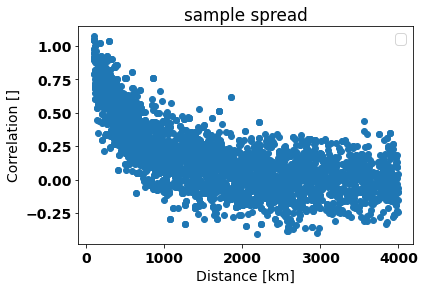

In [80]:


#I made one for V2 as well
plt.figure(7)
plt.title("sample spread")
plt.scatter(x,y)
#plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")


print("total no. of samples for ADS",len(x))

action point: define a grid with 1 dec place (for noise), 2 grid versions (one with while loop and another with error dampening), implement same sampling methods on the grid, then run each algorithm 1000x and take mean of the samples, plot with error graphs to gauge spread.